In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.base import clone

from processing_functions import *

In [78]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data/input_file.csv')
#nan_percentage(df) 

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [60]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df_final = df.drop(columns=['Unnamed: 0'])
df_try = df_final.copy(deep=True)

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [61]:
df_final.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,4,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [62]:
df_final = df_final.dropna()
print(df_final.columns)

Index(['iid', 'id', 'wave', 'partner', 'pid', 'match', 'int_corr', 'age_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'like_o', 'prob_o', 'age', 'imprelig', 'goal', 'date', 'go_out',
       'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
       'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
       'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr_important',
       'sinc_important', 'intel_important', 'fun_important', 'amb_important',
       'shar_important', 'attr_self', 'sinc_self', 'fun_self', 'intel_self',
       'amb_self', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
       'like', 'prob'],
      dtype='object')


In [63]:
# Dropping identifier columns and irrelevant features for prediction
df = df_final.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [64]:
df.head()

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0


In [65]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)
xgb_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())
print("XGBClassifier Accuracy: ", xgb_accuracy.mean())

Random Forest Accuracy:  0.844
LightGBM Accuracy:  0.8386666666666667
XGBClassifier Accuracy:  0.8413333333333334


In [11]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report
print("RandomForestClassifier:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("LightGBM:\n", classification_report(y_pred_lgb, y_test))
print("XGBClassifer:\n", classification_report(y_pred_xgb, y_test))

print("\n")

# F1 Score
print("RandomForestClassifier F1 score:\n", f1_score(y_test, y_pred_rf, zero_division=0, average="weighted"),"\n")
print("LightGBM F1 score:\n", f1_score(y_pred_lgb, y_test, average="weighted"),"\n")
print("XGBClassifer F1 score:\n", f1_score(y_pred_xgb, y_test, average="weighted"))

RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.89      0.97      0.92       208
           1       0.71      0.40      0.51        43

    accuracy                           0.87       251
   macro avg       0.80      0.68      0.72       251
weighted avg       0.86      0.87      0.85       251

LightGBM:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       209
           1       0.58      0.60      0.59        42

    accuracy                           0.86       251
   macro avg       0.75      0.75      0.75       251
weighted avg       0.86      0.86      0.86       251

XGBClassifer:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       214
           1       0.53      0.62      0.57        37

    accuracy                           0.86       251
   macro avg       0.73      0.76      0.75       251
weighted avg       0.87

In [12]:
df['match'].value_counts(normalize=True)

0    0.800319
1    0.199681
Name: match, dtype: float64

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [13]:
def pr_threshold(model, model_name='Model'):
    """
    Calculate and plot the precision-recall curve for a given model and test data.
    Also, find the threshold that yields the highest F1 score using an iterative method and plot the classification report based on this threshold.

    Parameters:
    model: The trained classifier to evaluate.
    X_test: The test features.
    y_test: The true labels for the test set.
    model_name (optional): Name of the model to include in the plot title.

    Returns:
    optimal_threshold: The threshold value that yields the highest F1 score.
    optimal_report: Classification report using the optimal threshold.
    """
    # probabilities for the positive class
    probabilities = model.predict_proba(X_val)[:,1]

    # precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)

    # F1 score for each threshold with tiny constant to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)

    # Find the index of the maximum F1 score
    optimal_index = np.argmax(fscore)
    best_threshold = thresholds[optimal_index]

    # Make final predictions using the optimal threshold
    final_predictions = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12), 'r-.', label='F1 Score')
    plt.axvline(x=best_threshold, color='k', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Precision, Recall, and F1 Score for different thresholds')
    plt.show()

    optimal_report = classification_report(y_test, final_predictions, zero_division=0)
    return best_threshold, optimal_report

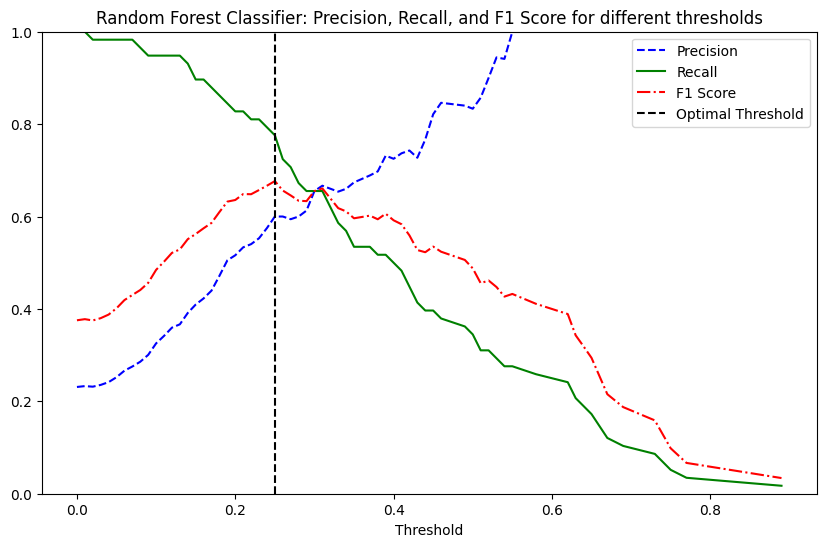

Optimal threshold for maximum Random Forest F1-score: 0.25
Using threshold ~0.2500 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       208
           1       0.38      0.70      0.50        43

    accuracy                           0.76       251
   macro avg       0.65      0.73      0.67       251
weighted avg       0.83      0.76      0.78       251
 

Random Forest: f1 score 0.8842964733961732


In [14]:
optimal_threshold_rf, optimal_report_rf = pr_threshold(rf_model, model_name='Random Forest Classifier')

print("Optimal threshold for maximum Random Forest F1-score:", optimal_threshold_rf)
print(f"Using threshold ~{optimal_threshold_rf:.4f} for evaluation.\n")
print(optimal_report_rf, "\n")

final_predictions_rf = (rf_model.predict(X_test) >= 0.25).astype(int)
print("Random Forest: f1 score", f1_score(final_predictions_rf, y_test, average="weighted"))

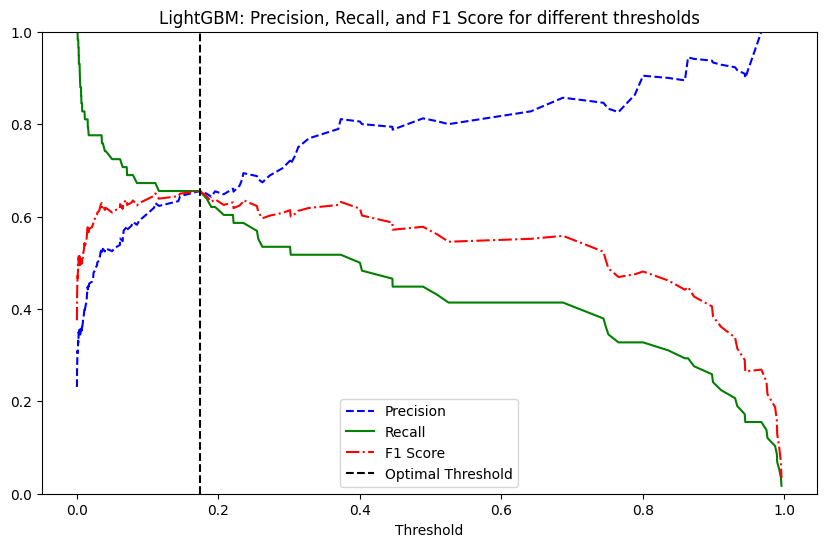

Optimal threshold for maximum LightGBM F1-score: 0.17378639520254496
Using threshold ~0.1738 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       208
           1       0.53      0.65      0.58        43

    accuracy                           0.84       251
   macro avg       0.73      0.77      0.74       251
weighted avg       0.86      0.84      0.85       251

LightGBM: F1 score 0.8612108204226402


In [15]:
optimal_threshold_lgb, optimal_report_lgb = pr_threshold(lgb_model, model_name='LightGBM')

print("Optimal threshold for maximum LightGBM F1-score:", optimal_threshold_lgb)
print(f"Using threshold ~{optimal_threshold_lgb:.4f} for evaluation.\n")
print(optimal_report_lgb)

final_predictions_lgb = (lgb_model.predict(X_test) >= optimal_threshold_lgb).astype(int)
print("LightGBM: F1 score", f1_score(final_predictions_lgb, y_test, average="weighted"))

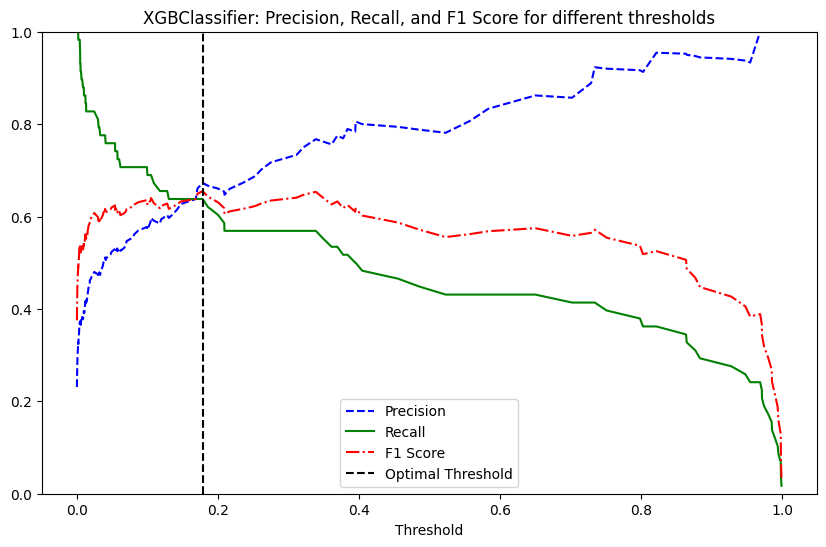

Optimal threshold for maximum XGBClassifier F1-score: 0.17816627
Using threshold ~0.1782 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       208
           1       0.50      0.67      0.57        43

    accuracy                           0.83       251
   macro avg       0.71      0.77      0.73       251
weighted avg       0.85      0.83      0.84       251

XGBClassifier: F1 score 0.8686585411906875


In [16]:
optimal_threshold_xgb, optimal_report_xgb = pr_threshold(xgb_model, model_name='XGBClassifier')

print("Optimal threshold for maximum XGBClassifier F1-score:", optimal_threshold_xgb)
print(f"Using threshold ~{optimal_threshold_xgb:.4f} for evaluation.\n")
print(optimal_report_xgb)

final_predictions_xgb = (xgb_model.predict(X_test) >= optimal_threshold_xgb).astype(int)
print("XGBClassifier: F1 score", f1_score(final_predictions_xgb, y_test, average="weighted"))

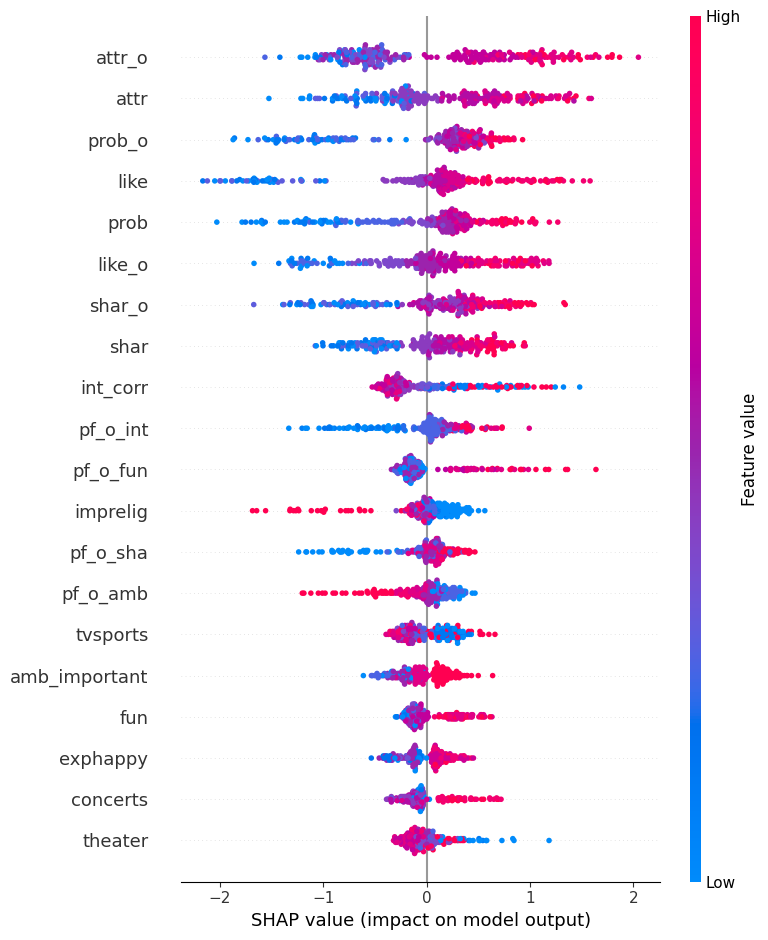

In [17]:
explainer = shap.Explainer(lgb_model, X_train)
shap_values_lgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgb, X_test)

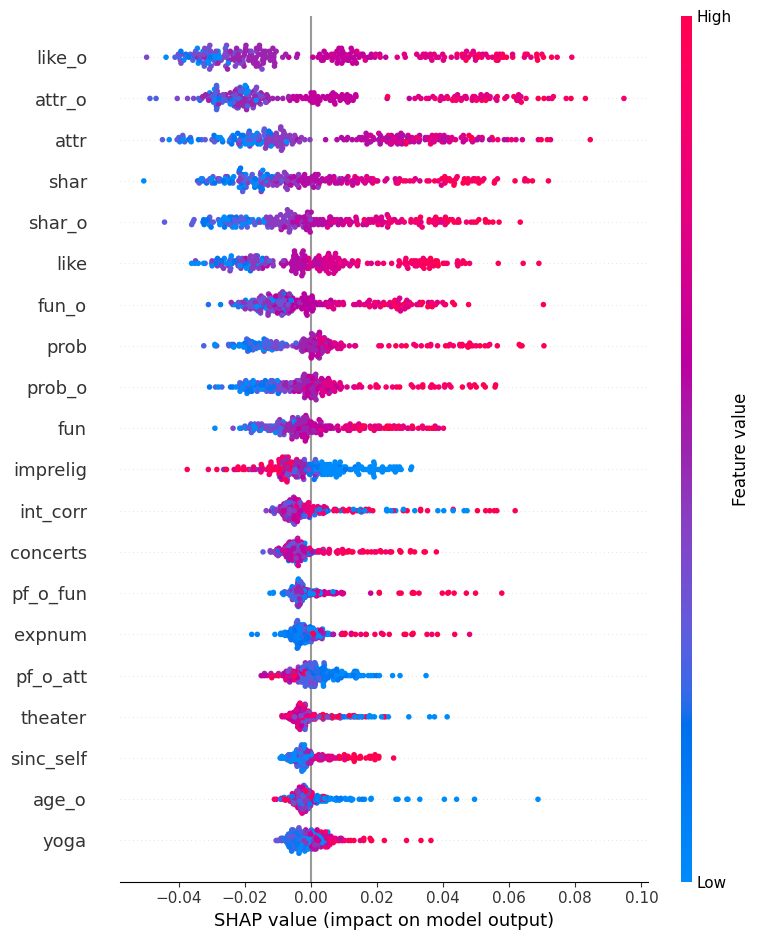

In [18]:
explainer = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values_rf[1], X_test)

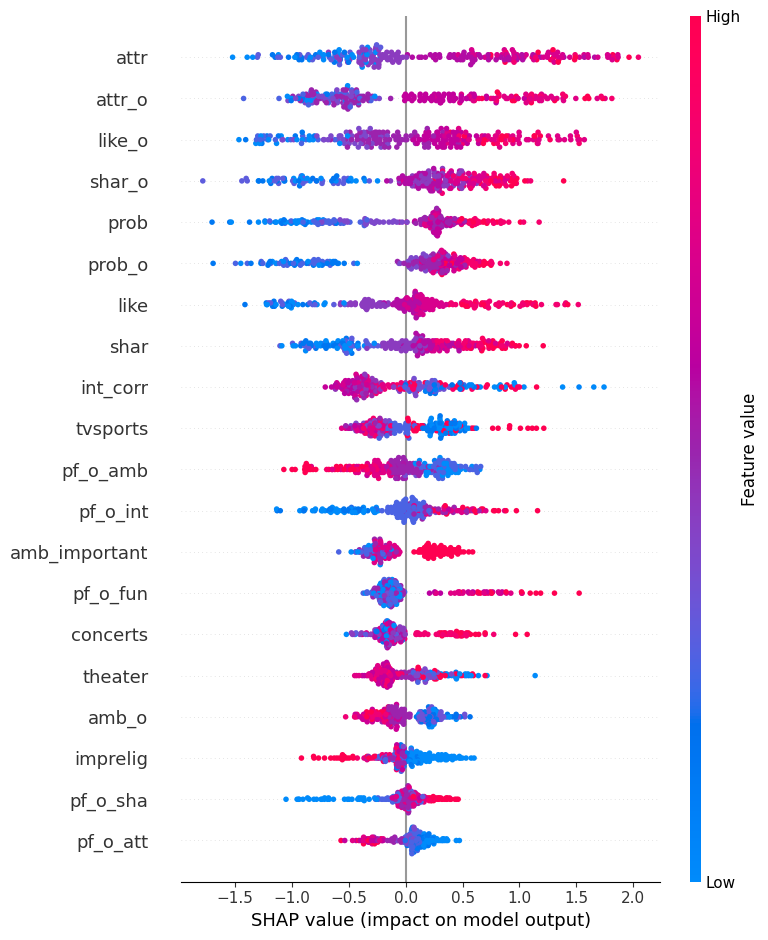

In [19]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_xgb, X_test)

In [20]:
def shap_importance(model):
    """
    Return a dataframe containing the features sorted by Shap importance.

    Parameters:
    model : The tree-based model (like RandomForest, XGBoost, etc.).
    X_train : pd.DataFrame
        Training set used to train the model (without the label).
    X_test : pd.DataFrame
        Test set or any set to compute SHAP values (without the label).

    Returns:
    pd.DataFrame
        A dataframe containing the features sorted by Shap importance.
    """
    explainer = shap.Explainer(model, X_train)
    
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values[1])
    else:
        shap_values = np.abs(shap_values)
        
    mean_abs_shap_values = shap_values.mean(axis=0)
    
    feature_importance = pd.DataFrame({
        'features': X_test.columns,
        'importance': mean_abs_shap_values
    })
    
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    return feature_importance.reset_index(drop=True).head(30)

In [21]:
shap_importance(rf_model)

,features,importance
0,like_o,0.027976
1,attr_o,0.026646
2,attr,0.025522
3,shar,0.020379
4,shar_o,0.018735
5,like,0.017369
6,fun_o,0.014560
7,prob,0.013746
8,prob_o,0.011929
9,fun,0.010992


In [69]:
print(df_final['iid'].unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 115 116 117 119 120 121 122 123 124 125 126 127 128 130 131]


In [75]:
def wave_matches_display(df):
    # Dictionary to store data for each wave
    wave_data = {}

    # Group by wave and process each group
    for wave, group in df.groupby('wave'):
        # Collect all participants in the wave
        participants = list(group['iid'].unique())
        
        # Collect matches as lists of pairs
        matches = []
        for index, person in group.iterrows():
            if person['match'] == 1 and person['pid'] in group['iid'].values:
                matches.append([person['iid'].astype(int), person['pid'].astype(int)])
        
        # Storing results in the dictionary with wave as key
        wave_data[wave] = {
            "participants": participants,
            "matches": matches
        }

    # Convert the dictionary into a DataFrame
    wave_df = pd.DataFrame([
        {'wave': wave, 'participants': data['participants'], 'matches': data['matches']}
        for wave, data in wave_data.items()
    ])

    return wave_df

wave_df = wave_matches_display(df_final)
wave_df_try = wave_matches_display(df_try)

In [77]:
wave_df['participants']

0                                                                                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1                        [21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
2                                                                                    [56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
3    [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
4                                                                       [112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131]
Name: participants, dtype: object

In [79]:
wave_df_try

,wave,participants,matches
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[[1, 13], [1, 14], [1, 15], [1, 19], [2, 14], [2, 19], [4, 14], [4, 19], [5, 14], [5, 19], [6, 14], [6, 19], [7, 14], [7, 19], [8, 12], [8, 13], [8, 14], [8, 15], [8, 16], [8, 18], [8, 19], [8, 20], [9, 12], [9, 13], [9, 14], [9, 15], [9, 16], [9, 17], [9, 19], [10, 13], [10, 19], [12, 8], [12, 9], [13, 1], [13, 8], [13, 9], [13, 10], [14, 1], [14, 2], [14, 4], [14, 5], [14, 6], [14, 7], [14, 8], [14, 9], [15, 1], [15, 8], [15, 9], [16, 8], [16, 9], [17, 9], [18, 8], [19, 1], [19, 2], [19, 4], [19, 5], [19, 6], [19, 7], [19, 8], [19, 9], [19, 10], [20, 8]]"
1,2,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]","[[22, 44], [22, 45], [23, 43], [23, 44], [23, 45], [27, 46], [27, 50], [28, 46], [29, 44], [29, 45], [30, 49], [30, 55], [31, 48], [31, 49], [31, 50], [31, 55], [34, 46], [34, 49], [35, 45], [35, 46], [35, 49], [35, 50], [35, 53], [36, 49], [36, 51], [37, 44], [37, 52], [38, 49], [38, 50], [38, 55], [39, 47], [43, 23], [44, 22], [44, 23], [44, 29], [44, 37], [45, 22], [45, 23], [45, 29], [45, 35], [46, 27], [46, 28], [46, 34], [46, 35], [47, 39], [48, 31], [49, 30], [49, 31], [49, 34], [49, 35], [49, 36], [49, 38], [50, 27], [50, 31], [50, 35], [50, 38], [51, 36], [52, 37], [53, 35], [55, 30], [55, 31], [55, 38]]"
2,3,"[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]","[[56, 69], [56, 70], [57, 71], [58, 71], [58, 74], [60, 66], [61, 71], [61, 75], [62, 67], [62, 69], [62, 74], [63, 67], [64, 75], [66, 60], [67, 62], [67, 63], [69, 56], [69, 62], [70, 56], [71, 57], [71, 58], [71, 61], [74, 58], [74, 62], [75, 61], [75, 64]]"
3,4,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]","[[76, 94], [76, 105], [76, 107], [76, 109], [76, 110], [77, 94], [77, 97], [77, 98], [77, 99], [77, 105], [77, 107], [78, 106], [78, 107], [78, 109], [79, 104], [79, 107], [79, 108], [80, 102], [80, 105], [80, 109], [81, 99], [81, 104], [81, 108], [82, 94], [82, 99], [82, 105], [82, 107], [82, 109], [83, 99], [83, 107], [84, 105], [84, 108], [85, 107], [86, 97], [86, 100], [86, 104], [86, 105], [86, 107], [86, 108], [86, 109], [86, 110], [87, 99], [87, 107], [89, 99], [89, 104], [90, 109], [91, 97], [91, 99], [91, 103], [91, 105], [91, 106], [91, 107], [91, 109], [91, 110], [92, 97], [92, 98], [92, 99], [92, 105], [92, 107], [92, 109], [92, 110], [93, 95], [93, 97], [93, 100], [93, 104], [94, 76], [94, 77], [94, 82], [95, 93], [97, 77], [97, 86], [97, 91], [97, 92], [97, 93], [98, 77], [98, 92], [99, 77], [99, 81], [99, 82], [99, 83], [99, 87], [99, 89], [99, 91], [99, 92], [100, 86], [100, 93], [102, 80], [103, 91], [104, 79], [104, 81], [104, 86], [104, 89], [104, 93], [105, 76], [105, 77], [105, 80], [105, 82], [105, 84], [105, 86], [105, 91], ...]"
4,5,"[112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131]","[[112, 122], [112, 125], [112, 126], [112, 127], [112, 128], [112, 129], [113, 125], [113, 126], [113, 128], [114, 128], [115, 125], [115, 127], [115, 128], [116, 122], [116, 125], [116, 127], [116, 129], [117, 125], [119, 125], [119, 127], [119, 128], [119, 129], [119, 130], [120, 122], [120, 125], [120, 128], [120, 130], [122, 112], [122, 116], [122, 120], [125, 112], [125, 113], [125, 115], [125, 116], [125, 117], [125, 119], [125, 120], [126, 112], [126, 113], [127, 112], [127, 115], [127, 116], [127, 119], [128, 112], [128, 113], [128, 114], [128, 115], [128, 119], [128, 120], [129, 112], [129, 116], [129, 119], [130, 119], [130, 120]]"
5,6,"[132, 133, 134, 135, 136, 137, 138, 139, 140, 141]","[[132, 140], [134, 137], [135, 140], [135, 141], [136, 138], [137, 134], [138, 136], [140, 132], [140, 135], [141, 135]]"
6,7,"[142, 143, 144, 145, 146, 147, 148, 149

In [80]:
def predict_matches(person_id, df, model, age_range=5):
    """
    Predicts matches for a given person based on their attributes, their importance, and the trained model.
    
    Args:
    - person_id (int): The ID of the person for whom to predict potential matches.
    - df (DataFrame): The full preprocessed DataFrame that includes all participants.
    - model (trained model): The trained machine learning model.
    - age_range (int): Acceptable age difference.
    
    Returns:
    - DataFrame containing the sorted list of potential matches and their match probabilities.
    """
    # Extract the specific row for the person
    person_data = df.loc[person_id]
    person_wave = person_data['wave']
    
    # Filter for same wave and acceptable age difference
    wave_group = df[df['wave'] == person_wave]
    compatible_ages = wave_group[(wave_group['age'] >= person_data['age'] - age_range) & 
                                 (wave_group['age'] <= person_data['age'] + age_range)]
    
    # Prepare the DataFrame to store match probabilities
    probabilities = []
    for other_id, other_data in compatible_ages.iterrows():
        if other_id != person_id:  # Ensure not comparing the person to themselves
            # Calculate a weighted score based on importance and ratings
            weighted_score = 0
            attributes = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']
            for attr in attributes:
                weighted_score += (person_data[attr + '_important'] * other_data[attr] + 
                                   other_data[attr + '_important'] * person_data[attr])

            # Adjust score with like, int_corr, and goal similarity
            weighted_score += (abs(person_data['like'] - other_data['like']) +
                               abs(person_data['int_corr'] - other_data['int_corr']) +
                               (person_data['goal'] == other_data['goal']) * 10)

            # Predict probability of match
            input_features = prepare_features(person_data, other_data)  # This needs to be defined
            proba = model.predict_proba(input_features)[:, 1]
            weighted_proba = proba * weighted_score
            
            probabilities.append((other_id, weighted_proba.item()))
    
    # Create a DataFrame of probabilities and sort by probability descending
    probabilities_df = pd.DataFrame(probabilities, columns=['other_id', 'probability'])
    probabilities_df.sort_values(by='probability', ascending=False, inplace=True)
    
    return probabilities_df

In [81]:
predict_matches(416, df_try, rf_model, age_range=5)

NameError: name 'prepare_features' is not defined